In [1]:
%pylab inline --no-import-all
import math
import george
import numpy as np
import emcee

import scipy.optimize as so
import scipy.special as ssp
from iminuit import Minuit
import ROOT as r
import matplotlib.ticker as ticker
import matplotlib.cm as cmap
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt
from george.kernels import ExpSquaredKernel

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


### the kernel, or covariance structure, is what defines a Gaussian Process. 
### Initially, you'll start with a Exponential Squared kernel with a mean of a standard fit function used for the analysis. Having a mean function means you're modeling the fluctuations of your data around the fit function. The Gaussian Process is still flexible enough to fit the data even if the fit function doesn't fit the data well - i.e. you shouldn't need to spend time testing out different fit functions. As long as it describes the data fairly well, it should work. 
### The exponential squared kernel is a fairly basic kernel that says the covariance between points should die off as 1/(x1-x2)^2. Most kernels you'll want for your analysis will have this feature - the farther points are away from each other, the less they effect each other. 
### the hyperparameters of the kernel let you fine tune your kernel. For instance, the exponential squared kernel has a length scale hyperparameter l, which is related to the smoothness of your kernel. Too small, and the GP will be allowed to fluctuate on short length scales. Too large, and you smear out features you want to fit.

###################################################################################################

#### Make a pretty plot overlaying a fit on data

In [2]:
def basicPlot(xs, ys, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(10,10))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10)
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_ylim([0.01, 2e6])
    
    ax1.set_xscale('log')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)

### For this tutorial, lets make a fake data set. Since I was originally working on the dijet analysis, lets make the dataset from a 5 parameter dijet fit function

In [10]:
def model_5param(t): 
    #because I already fit the 13TeV 3.6 fb-1 dijet dataset and here were the parameters
    p0, p1, p2, p3, p4 = (0.25, 9.8, -3.5, 0.61, 0.078)
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*np.append(np.diff(t), np.diff(t)[-1])

#### create some evenly spaced bins in log space, add some Poisson noise to this result of the fit function, and create a ROOT file with the histogram. Then make a pretty plot just to make sure everything looks ok

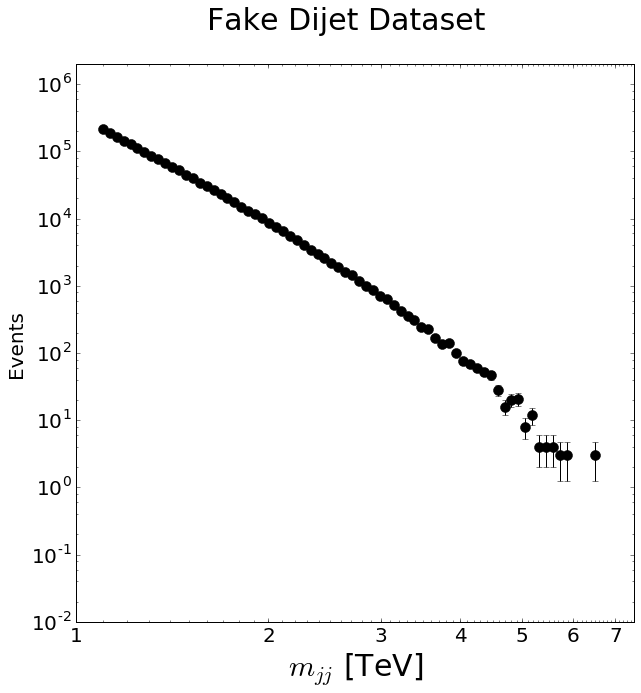

In [11]:
xbins = np.logspace(np.log10(1100), np.log10(7000), 75)
dataset = np.random.poisson(model_5param(xbins))
dataset_hist = r.TH1D("dataset", "dataset", len(xbins), xbins)
for ib in range(1,len(xbins)):
    dataset_hist.SetBinContent(ib, dataset[ib])
    dataset_hist.SetBinError(ib, math.sqrt(dataset[ib]))
dataset_file = r.TFile("inputData.root","RECREATE")
dataset_file.cd()
dataset_hist.Write()
dataset_file.Close()
basicPlot(xbins, dataset, "Fake Dijet Dataset")

# Basics fits
#### Fit GP to data or MC template

### Some useful functions

#### Calculate the z-val and chi squared fit between data and fit. The signficance is plotted in the bottom panel of makePrettyPlots

In [12]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### Make a pretty plot of fit overlaid on data in the top panel and the signficance plotted in the bottom panel

In [13]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e6):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.1, ymax])
  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(binedges,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  
    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



#### grab your data or MC from root file and save points in arrays to be used in GP fit

In [14]:
input_file = r.TFile("inputData.root", "OPEN")
input_hist = input_file.Get("dataset")
ycounts = []
yerrs = []
xbins = []
xerrs = []
binedges = []
for ib in range(1,input_hist.GetNbinsX()):
    ycounts.append(input_hist.GetBinContent(ib))
    yerrs.append(input_hist.GetBinError(ib))
    xbins.append(input_hist.GetBinCenter(ib))
    xerrs.append(input_hist.GetBinLowEdge(ib+1)-input_hist.GetBinLowEdge(ib))
    binedges.append(input_hist.GetBinLowEdge(ib))
input_file.Close()
ycounts = np.array(ycounts)
yerrs = np.array(yerrs)
xbins = np.array(xbins)
xerrs = np.array(xerrs)
np.save("ycounts", ycounts)
np.save("yerrs", yerrs)
np.save("xbins", xbins)
np.save("xerrs", xerrs)
#binedges = np.array(binedges)

### To fit Gaussian Process, set up a negative log likelihood minimization 

#### We're going to use a fit function as the mean of our GP. Set up the 3 parameter dijet function here with george - get_value is what is called in george to calculate the mean

In [15]:
from george.modeling import ModelingMixin
class Mean(ModelingMixin):
    def get_value(self, t):
        sqrts = 13000.
        return (self.p0 * (1.-t/sqrts)**self.p1 * (t/sqrts)**(self.p2))*np.append(np.diff(t), np.diff(t)[-1])


### Minimize using minuit

#### Use the built in method from george to get the log likelihood. Create a loglikelihood class to pass to minuit.  Instead of a separate prior, I'm just putting bounds on parameters in minuit. 
#### A more robust way of running minuit is to run the minimization multiple times and keep track of the lowest log likelihood value and its corresponding parameters, in case minuit settles into some local minima. You can of course just run it once, and it will mostly produce good results, and speed things up signficantly. 
#### Names of the input parameters in minuit must be the same as in the likelihood class. Set up the intial parameters, step sizes for each parameter (error), and bounds on the parameters (limit).  

In [16]:
class logLike_minuit:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, length, p0, p1, p2):
        kernel = Amp*ExpSquaredKernel(length)
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        gp.compute(self.x, np.sqrt(self.y))
        return -gp.lnlikelihood(self.y)

        
def fit_gp_minuit(num, lnprob):
    min_likelihood = np.inf
    best_fit_params = (0, 0, 0, 0, 0)
    for i in range(num):
        init0 = np.random.random() * 100.
        init1 = np.random.random() * 20.
        init2 = np.random.random() * 1. 
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  Amp = init0, length = init1, 
                   p0 = init2, p1 = init3, p2 = init4,
                   error_Amp = 1e1, error_length = 1e1,
                   error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (0.1, 1e10), limit_length = (100, 1e6), 
                   limit_p0 = (0,10), limit_p1 = (-20, 20), limit_p2 = (-20,20)) 
        m.migrad()
        if m.fval < min_likelihood:
            min_likelihood = m.fval
            best_fit_params = m.args 
    print "min LL", min_likelihood
    print "best fit vals", best_fit_params
    return min_likelihood, best_fit_params

#### To start with george, you must always intialize a george.GP object with a kernel. You can also add in a mean function as we've done here, but if one is not specified its set to 0. You can find more inforamtion about the different pre-made kernels, options for the GP object, mean functions, and how to build your own kernel at http://dan.iel.fm/george/current/.
#### In our case, we want to use a fit function as our mean (otherwise the GP will be modeling fluctuations around 0!). We're using the 3 parameter dijet fit function. We also set the arguement fit_mean = True so that the mean function parameters will also be fit, along with the kernel hyperparameters
#### Finally, you must always call gp.compute to precompute the covariance matrix at the independent coordinates before calling most other methods

In [17]:
p_init = [5, 1e3, 1e-1, 5, -5]
Amp, length, p0, p1, p2 = p_init

In [18]:
kernel = Amp*ExpSquaredKernel(length)
gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
gp.compute(xbins, yerrs)

#### Call your minuit minimzation

In [19]:
lnProb = logLike_minuit(xbins, ycounts, xerrs)
min_likelihood, best_fit_gp = fit_gp_minuit(100, lnProb)
Amp, length, p0, p1, p2 = best_fit_gp

np.save("fixedHyperparameters.npy",best_fit_gp)

min LL 345.477798718
best fit vals (1.5826395666596667, 218535.65928695325, 0.03798467356260715, 8.557114779861578, -5.224593417393155)


#### Finally, call predict to get the mean and variance of the predictive distribution. This is what we use as our GP fit. 

In [20]:
Amp, length, p0, p1, p2 = best_fit_gp
kernel = Amp*ExpSquaredKernel(length)
gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
gp.compute(xbins, yerrs)

meanGP, covGP = gp.predict(ycounts, xbins)

#### And make the pretty plot

chi2 2231.73832288


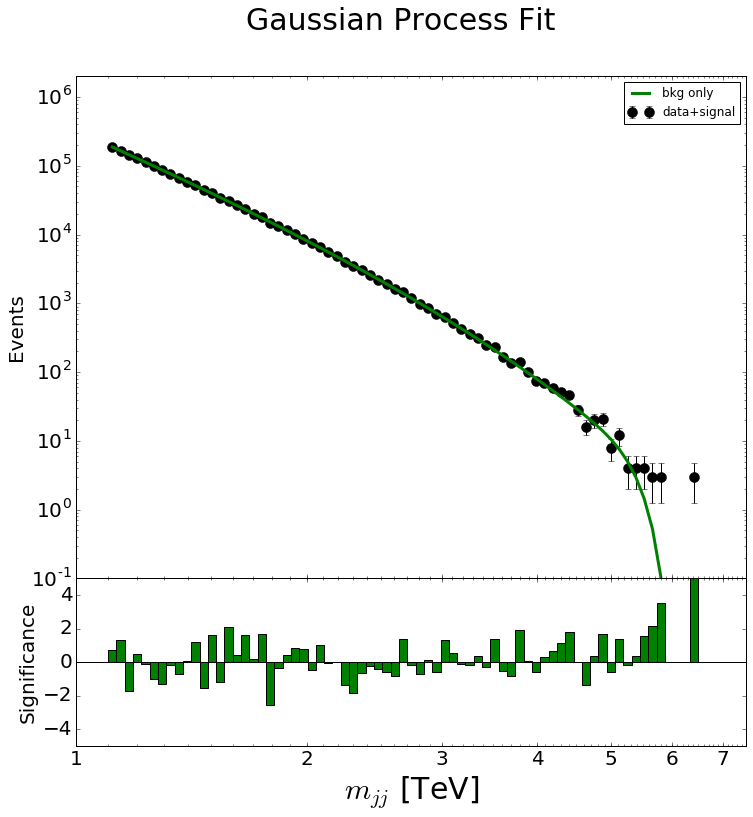

In [21]:
makePrettyPlots(xbins, ycounts, meanGP, "Gaussian Process Fit")

### Lets look at some samples from the posterior

#### First, something to make the plot look pretty and plot all those samples

In [22]:
def makePrettyPlots_samples(xs, ys, bkgFits, title, ymax = 1e6):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(10,7))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="Posterior samples")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.1, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

#### sample_conditional samples the predictive distribution (the same as the mean from above), where the 3rd arguement is the number of samples you want

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/george-1.0.0.dev0-py2.7-macosx-10.6-x86_64.egg/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.


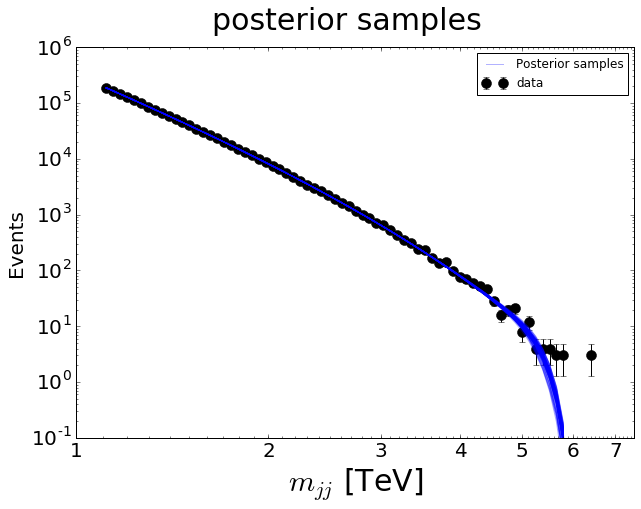

In [23]:
samps = gp.sample_conditional(ycounts, xbins, 100)
makePrettyPlots_samples(xbins, ycounts, samps, "posterior samples")

In [ ]:
###########

In [24]:
def makeToys(dataset, nPseudo=1000, lumi = 1.):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi)
        toys.append(pseudo)
    return toys

In [25]:
np.save("toys.npy",makeToys(model_5param(xbins)))

######################################################################################

######################################################################################

### MCMC - emcee

In [ ]:
def priors_emcee(params):
    Amp, length, p0, p1, p2 = params
    if 1e10 > Amp > 1 and 1e6 > length > 0 and 50 > p0 > 0 and 20 > p1 > -20 and 20 > p2 > -20:
        return 0
    else:
        return np.inf

def logLike_emcee(params, x, y, yerr):
    #gp.set_vector(np.log(params))
    prior = priors_emcee(params)
    if np.isinf(prior):
        return np.inf
    Amp, length, p0, p1, p2 = params
    kernel = Amp*ExpSquaredKernel(length)
    gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
    gp.compute(x, yerr)
    return -gp.lnlikelihood(y) 

In [ ]:
def fit_gp_emcee(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logLike_emcee, args=data)
    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler

In [ ]:
Amp, length, p0, p1, p2 = p_init
kernel = Amp*ExpSquaredKernel(length)
gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True) 
gp.compute(xbins, yerrs)

data = (xbins, ycounts, yerrs)
sampler = fit_gp_emcee(p_init, data)
samples = sampler.flatchain

meanGP, covGP = gp.predict(ycounts, xbins)

In [ ]:
sampleSet = np.empty([24, len(ycounts)])
for si, s in enumerate(samples[np.random.randint(len(samples), size=24)]):
    Amp, length, p0, p1, p2 = s
    kernel = Amp*ExpSquaredKernel(length)
    gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True) 
    gp.compute(xbins, yerrs)
    meanGP, covGP = gp.predict(ycounts, xbins)
    print meanGP
    sampleSet[si,:] = meanGP

In [ ]:
makePrettyPlots_samples(xbins, ycounts, sampleSet.tolist(), "title")

### Try scipy

#### Set up uniform priors on parameters - you can change this as you see fit. Use the built in method from george to get the log likelihood and gradient of the likelihood with respect to each parameter. set_vector sets the hyperparameters if they're changed from the initalization, but note set_vector/get_vector take in/return the log of the hyperparameters! 

In [ ]:
def priors(params):
    Amp, length, p0, p1, p2 = params
    if 1e10 > Amp > 0 and 1e5 > length > 0 and 50 > p0 > 0 and 20 > p1 > -20 and 20 > p2 > -20: 
        return 0
    else:
        return np.inf

        
def logLike_scipy(params, y, x, xerr):
    # Update the kernel parameters and compute the likelihood.
    #gp.set_vector(np.log(params))
    Amp, length, p0, p1, p2 = params
    kernel = Amp*ExpSquaredKernel(length)
    gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True) 
    gp.compute(xbins, yerrs)
    prior = priors(params)
    return -gp.lnlikelihood(y) + prior if np.isfinite(prior) else 1e25
    

def grad_logLike_scipy(params, y, x, xerr):
    # Update the kernel parameters and compute the likelihood.
    #gp.set_vector(np.log(params))
    Amp, length, p0, p1, p2 = params
    kernel = Amp*ExpSquaredKernel(length)
    gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True) 
    gp.compute(xbins, yerrs)
    grad_ll = gp.grad_lnlikelihood(y, quiet=True)
    return -grad_ll

        

####  To start with george, you must always intialize a george.GP object with a kernel. You can also add in a mean function as we've done here, but if one is not specified its set to 0.  You can find more inforamtion about the different pre-made kernels, options for the GP object, mean functions, and how to build your own kernel at (ref). 
#### In our case, we want to use a fit function as our mean (otherwise the GP will be modeling fluctuations around 0!). We're using the 3 parameter dijet fit function. We also set the arguement fit_mean = True so that the mean function parameters will also be fit, along with the kernel hyperparameters
#### Finally, you must always call gp.compute to precompute the covariance matrix at the independent coordinates before calling most other methods.

In [ ]:
p_init = [5, 1e5, 1e-1, 5, -5]
Amp, length, p0, p1, p2 = p_init

kernel = Amp*ExpSquaredKernel(length)
gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True) 

print "initial", np.exp(gp.get_vector())

gp.compute(xbins, yerrs)

#### Then, pass your likelihood functions with you initial hyperparameter guesses and the data into scipy.optimize.minimize. This will return your best fit hyperparameters, which you can set in your kernel/mean functions with gp.set_vector. You can put bounds on the parameters (bounds = [(min, max), (min, max)..]). 

In [ ]:
results = op.minimize(logLike_scipy, p_init, args = (ycounts, xbins, xerrs), jac=grad_logLike_scipy)
print "results", results.x
#gp.set_vector(np.log(results.x))

#### Finally, call predict to get the mean and variance of the predictive distribution. This is what we use as our GP fit. Then make a pretty plot to see how well it did

In [ ]:
Amp, length, p0, p1, p2 = results.x
kernel = Amp*ExpSquaredKernel(length)
gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True) 
gp.compute(xbins, yerrs)
meanGP, covGP = gp.predict(ycounts, xbins) 
makePrettyPlots(xbins, ycounts, meanGP, "Gaussian Process Fit")

#### Use 3 parameter fit function as mean

In [ ]:
def mean_function(params, t, xerr): 
    p0, p1, p2 = params
    #print p0, p1, p2
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

In [ ]:
class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = mean_function(params, self.x, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf

def fit_3ff(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 10:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * -6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2, 
                  limit_p0 = (0, 20.), limit_p1 = (-20., 20.), limit_p2 = (-20., 20.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 9: 
            print "retry number = ", 10, ": failed fits", lnprob.__class__.__name__
            minLLH=np.inf
            best_fit_params=(0, 0, 0)
        numRetries+=1 

    if Print:
        print "min LL", minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.) 
        return lnpoisson

In [ ]:
lnProb = logLike_3ff(xbins, ycounts ,xerrs)
ll_b3, best_fit_params = fit_3ff(lnProb, False)
print best_fit_params